# Shared Sentences Time Series Analysis

This notebook generates a time series graph showing the **average shared sentences count per day** across earnings call transcripts.

**Shared sentences** are sentences that contain keywords from both the **Activeness** and **Risk** keyword sets.

---

## Required Inputs

1. **Shared Sentences JSON file** - Contains shared sentence counts per document (e.g., `shared_sentences_20251125_220147.json`)
2. **Batch Summary CSV file** - Contains document metadata including dates (e.g., `batch_summary.csv`)

Both files should be in the same results directory (e.g., `data_analysis/results/2016/`).

## Step 1: Import Libraries

In [1]:
import json
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

## Step 2: Configure File Paths

**Edit the paths below** to point to your data files:

In [2]:
# =============================================================================
# CONFIGURATION - Edit these paths to match your data location
# =============================================================================

# Path to the shared sentences JSON file
JSON_PATH = "../data_analysis/results/2016/shared_sentences_20251125_220147.json"

# Path to the batch summary CSV file
CSV_PATH = "../data_analysis/results/2016/batch_summary.csv"

# Output path for the graph (optional - leave as None to auto-generate)
OUTPUT_PATH = None

# Year label for the graph title (optional - auto-detected from folder name if None)
YEAR = None

## Step 3: Load the Data

In [3]:
# Load shared sentences JSON
with open(JSON_PATH, 'r') as f:
    shared_data = json.load(f)

# Extract counts per document
shared_counts = {k: v['shared_sentences_count'] for k, v in shared_data.items()}

print(f"Loaded {len(shared_counts)} documents from JSON")
print(f"\nSample entries:")
for i, (k, v) in enumerate(list(shared_counts.items())[:3]):
    print(f"  {k}: {v} shared sentences")

Loaded 26049 documents from JSON

Sample entries:
  5897588_T.xml: 0 shared sentences
  5906894_T.xml: 2 shared sentences
  5978540_T.xml: 1 shared sentences


In [4]:
# Load batch summary CSV
batch_df = pd.read_csv(CSV_PATH)
batch_df['date'] = pd.to_datetime(batch_df['date'])

print(f"Loaded {len(batch_df)} documents from CSV")
print(f"\nColumns: {list(batch_df.columns)}")
print(f"\nDate range: {batch_df['date'].min().date()} to {batch_df['date'].max().date()}")

Loaded 26091 documents from CSV

Columns: ['HIV4', 'LM', 'ML', 'automated_readability_index', 'city', 'coleman_liau_index', 'company_name', 'company_ticker', 'dale_chall_readability_score', 'date', 'difficult_words', 'event_title', 'file_name', 'flesch_kincaid_grade', 'flesch_reading_ease', 'gunning_fog', 'linsear_write_formula', 'num_sentences', 'num_words', 'quarter', 'sentiment', 'smog_index', 'text_standard', 'time']

Date range: 2016-01-04 to 2016-12-30


## Step 4: Merge and Process Data

In [ ]:
# Merge shared sentence counts with batch summary by file_name
batch_df['shared_sentences_count'] = batch_df['file_name'].map(shared_counts)

# Filter to matched documents only
matched_df = batch_df.dropna(subset=['shared_sentences_count'])

print(f"Documents in JSON: {len(shared_counts)}")
print(f"Documents in CSV: {len(batch_df)}")
print(f"Matched documents: {len(matched_df)}")

if len(matched_df) < len(batch_df):
    unmatched = len(batch_df) - len(matched_df)
    print(f"\nNote: {unmatched} documents in CSV did not have matching entries in JSON")

Documents in JSON: 26049
Documents in CSV: 26091
Matched documents: 26078

Note: 13 documents in CSV did not have matching entries in JSON


In [6]:
# Compute daily average shared sentences count
daily_avg = matched_df.groupby('date')['shared_sentences_count'].mean().reset_index()
daily_avg = daily_avg.sort_values('date')

print(f"Number of unique days with earnings calls: {len(daily_avg)}")
print(f"\nDaily Average Shared Sentences - Summary Statistics:")
print(daily_avg['shared_sentences_count'].describe())

Number of unique days with earnings calls: 285

Daily Average Shared Sentences - Summary Statistics:
count    285.000000
mean       4.123473
std        1.800482
min        1.000000
25%        3.150485
50%        3.918831
75%        4.545455
max       17.000000
Name: shared_sentences_count, dtype: float64


## Step 5: Generate Time Series Graph

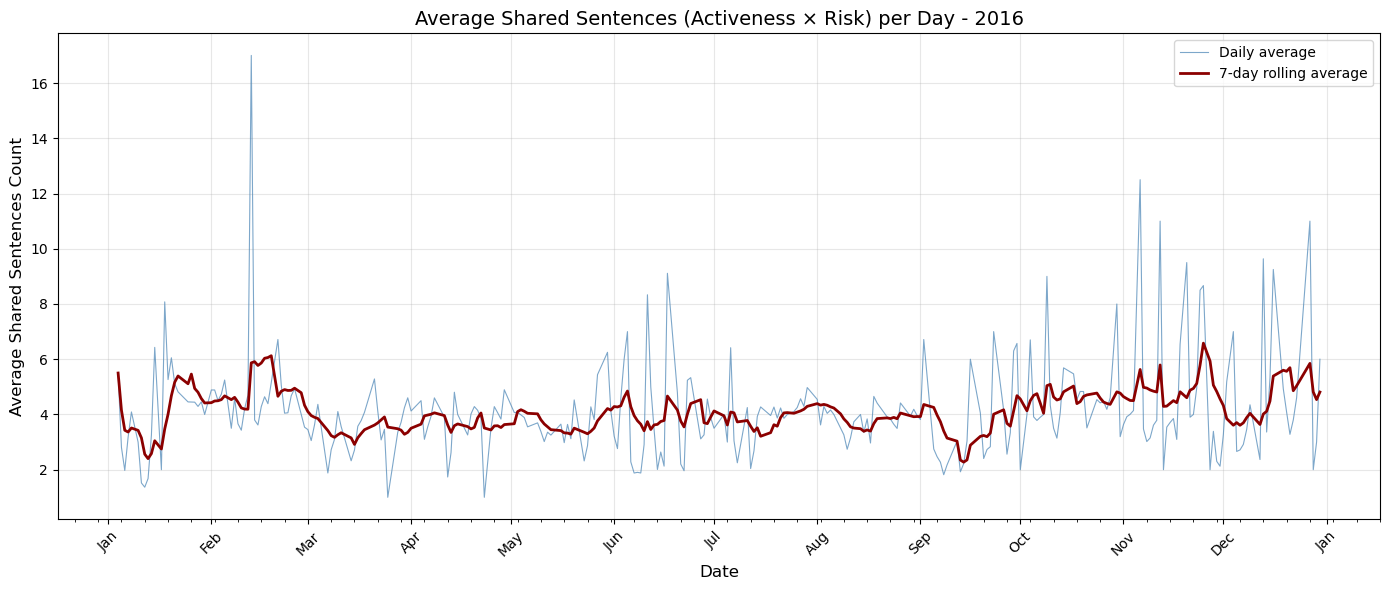

In [7]:
# Auto-detect year from folder name if not specified
year = YEAR
if year is None:
    json_parent = Path(JSON_PATH).parent.name
    if json_parent.isdigit() and len(json_parent) == 4:
        year = json_parent

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot daily values (light blue line)
ax.plot(daily_avg['date'], daily_avg['shared_sentences_count'],
        linewidth=0.8, alpha=0.7, color='steelblue', label='Daily average')

# Add 7-day rolling average (dark red line)
daily_sorted = daily_avg.set_index('date').sort_index()
rolling_avg = daily_sorted['shared_sentences_count'].rolling(window=7, min_periods=1).mean()
ax.plot(rolling_avg.index, rolling_avg.values,
        linewidth=2, color='darkred', label='7-day rolling average')

# Labels and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Average Shared Sentences Count', fontsize=12)

title = 'Average Shared Sentences (Activeness × Risk) per Day'
if year:
    title += f' - {year}'
ax.set_title(title, fontsize=14)

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

plt.xticks(rotation=45)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Save the Graph (Optional)

In [8]:
# Determine output path
if OUTPUT_PATH is None:
    output_path = Path(JSON_PATH).parent / 'shared_sentences_timeseries.png'
else:
    output_path = Path(OUTPUT_PATH)

# Recreate and save the plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_avg['date'], daily_avg['shared_sentences_count'],
        linewidth=0.8, alpha=0.7, color='steelblue', label='Daily average')

daily_sorted = daily_avg.set_index('date').sort_index()
rolling_avg = daily_sorted['shared_sentences_count'].rolling(window=7, min_periods=1).mean()
ax.plot(rolling_avg.index, rolling_avg.values,
        linewidth=2, color='darkred', label='7-day rolling average')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Average Shared Sentences Count', fontsize=12)

title = 'Average Shared Sentences (Activeness × Risk) per Day'
if year:
    title += f' - {year}'
ax.set_title(title, fontsize=14)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

plt.xticks(rotation=45)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.close()

print(f"Graph saved to: {output_path}")

Graph saved to: ../data_analysis/results/2016/shared_sentences_timeseries.png
